In [2]:
import os,sys,inspect

import pnsolver

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import util
import stencil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets
from ipywidgets.widgets.interaction import interact

import scipy.io


## Multigrid: Standard Poisson Problem vs. PN-Problem

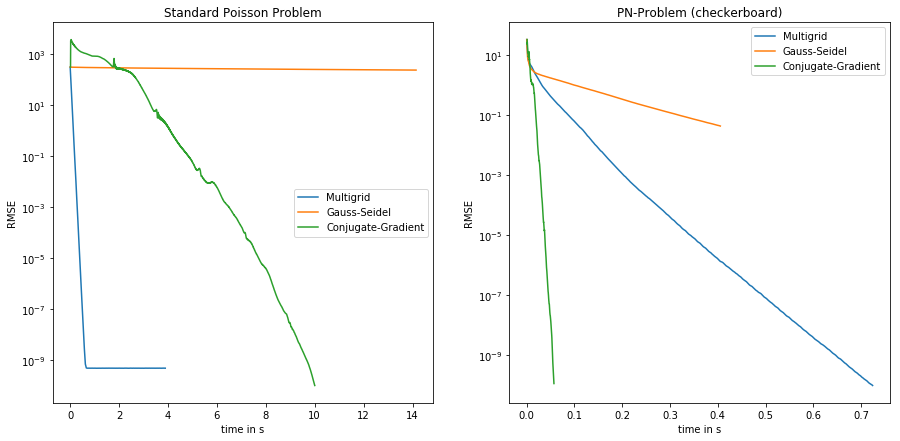

In [148]:
def plot_timings( filename ):
    data = scipy.io.loadmat(filename)
    convergence_mg = data["convergence_mg"][0]
    convergence_time_mg = data["timestamps_mg"][0]
    convergence_gs = data["convergence_gs"][0]
    convergence_time_gs = data["timestamps_gs"][0]
    convergence_cg = data["convergence_cg"][0]
    convergence_time_cg = data["timestamps_cg"][0]
    plt.semilogy( convergence_time_mg, convergence_mg, label="Multigrid" )
    plt.semilogy( convergence_time_gs, convergence_gs, label="Gauss-Seidel" )
    plt.semilogy( convergence_time_cg, convergence_cg, label="Conjugate-Gradient" )
def plot_timings2( filename ):
    data = scipy.io.loadmat(filename)
    convergence_mg = data["convergence_mg"][0]
    convergence_time_mg = data["timestamps_mg"][0]
    #convergence_mg2 = data["convergence_mg2"][0]
    #convergence_time_mg2 = data["timestamps_mg2"][0]
    convergence_gs = data["convergence_gs"][0]
    convergence_time_gs = data["timestamps_gs"][0]
    convergence_cg = data["convergence_cg"][0]
    convergence_time_cg = data["timestamps_cg"][0]
    plt.semilogy( convergence_time_mg, convergence_mg, label="Multigrid" )
    #plt.semilogy( convergence_time_mg2, convergence_mg2, label="Multigrid2" )
    plt.semilogy( convergence_time_gs, convergence_gs, label="Gauss-Seidel" )
    plt.semilogy( convergence_time_cg, convergence_cg, label="Conjugate-Gradient" )
    
fig = plt.figure(figsize=(15,7));
ax = fig.add_subplot(121)
plt.title("Standard Poisson Problem")
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/poisson_test.mat"
plot_timings(filename)
plt.legend(loc='best')
plt.xlabel('time in s')
plt.ylabel('RMSE')

ax = fig.add_subplot(122)
plt.title("PN-Problem (checkerboard)")
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
plot_timings2(filename)
plt.legend(loc='best')
plt.xlabel('time in s')
plt.ylabel('RMSE')

plt.show()

Both problems use the same solver code. The only thing which is changed per probem, are the matrices A and the restriction- and interpolation-matrices on each level.

The timings are different, because the standard problem is solved on a much larger grid, which also explains why Gauss-Seidel is just a straigh line there. However, even for much lower resolution, the multigrid solve will always be faster for the standard problem.

The correctness of the Multigrid solver is validated by showing, that its results matches the result from the Conjugate-gradient solver:

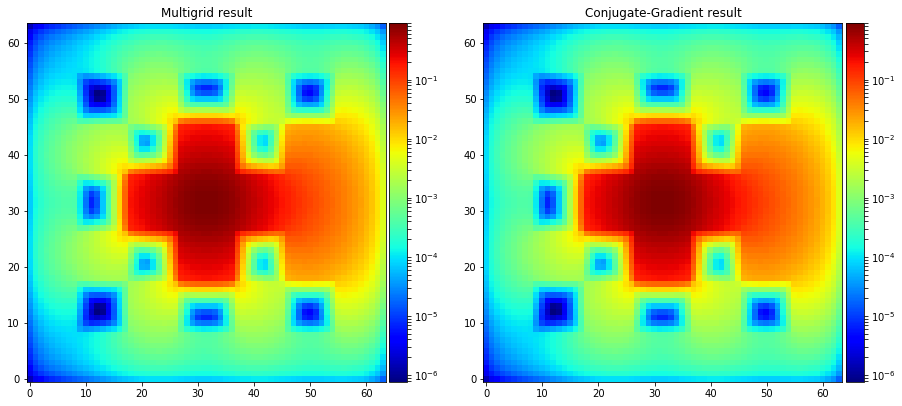

In [70]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
data = scipy.io.loadmat(filename)
image_mg = util.extract_coefficient_field( data["x_mg"], data["resolution"][0], data["numCoeffs"][0][0], 0 )
image_mg = np.clip(image_mg, 1.0e-8, np.max(image_mg))
image_cg = util.extract_coefficient_field( data["x_cg"], data["resolution"][0], data["numCoeffs"][0][0], 0 )
image_cg = np.clip(image_cg, 1.0e-8, np.max(image_cg))

fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(121)
plt.title("Multigrid result")
img_view = ax.imshow(image_mg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

ax = fig.add_subplot(122)
plt.title("Conjugate-Gradient result")
img_view = ax.imshow(image_cg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

plt.show()

To make sure, that up- and downsampling works properly, we show the effect of applying up and downsampling matrices to the solution:

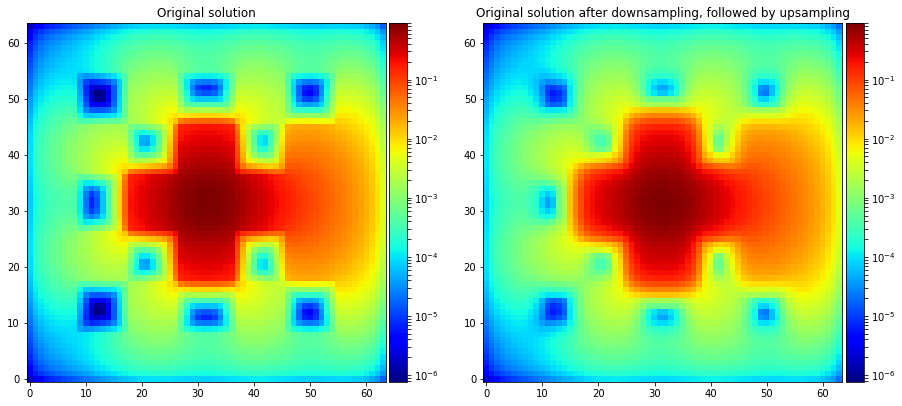

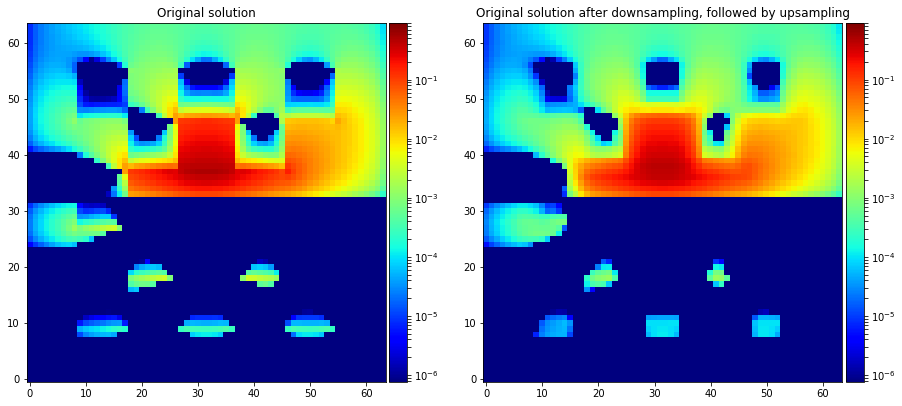

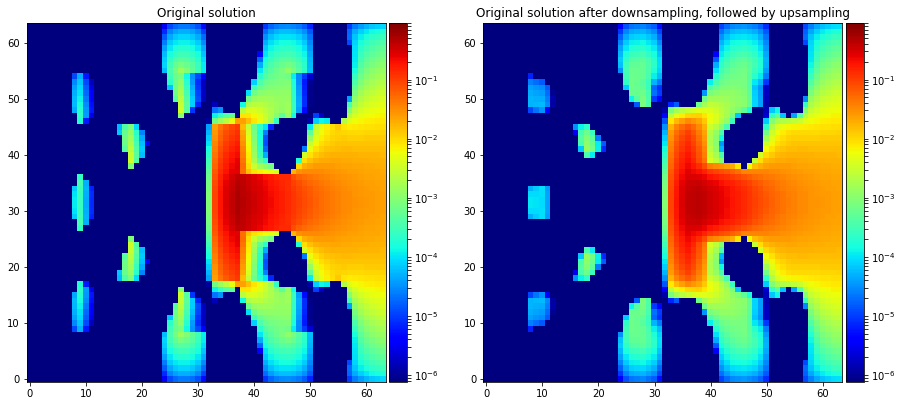

In [76]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
numCoeff = data["numCoeffs"][0][0]
for coeff in range(numCoeff):
    data = scipy.io.loadmat(filename)
    image_mg = util.extract_coefficient_field( data["debug_x"], data["resolution"][0], numCoeffs, coeff )
    image_mg = np.clip(image_mg, 1.0e-8, np.max(image_mg))
    image_cg = util.extract_coefficient_field( data["debug_x_upsampled_downsampled"], data["resolution"][0], numCoeffs, coeff )
    image_cg = np.clip(image_cg, 1.0e-8, np.max(image_cg))

    fig = plt.figure(figsize=(15,15));
    ax = fig.add_subplot(121)
    plt.title("Original solution")
    img_view = ax.imshow(image_mg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    ax = fig.add_subplot(122)
    plt.title("Original solution after downsampling, followed by upsampling")
    img_view = ax.imshow(image_cg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    plt.show()

-----------------------------

### Homogeneous solution

Does strong heterogenity cause poor multigrid performance? No.


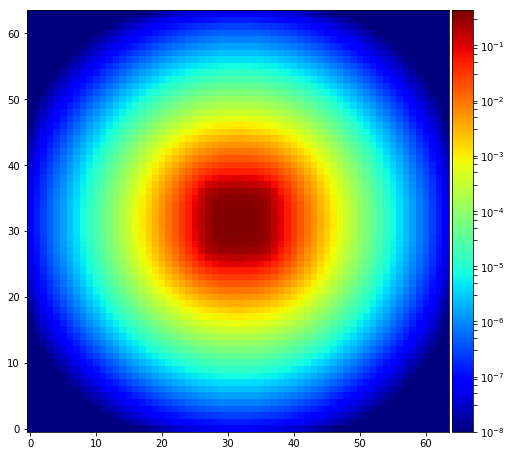

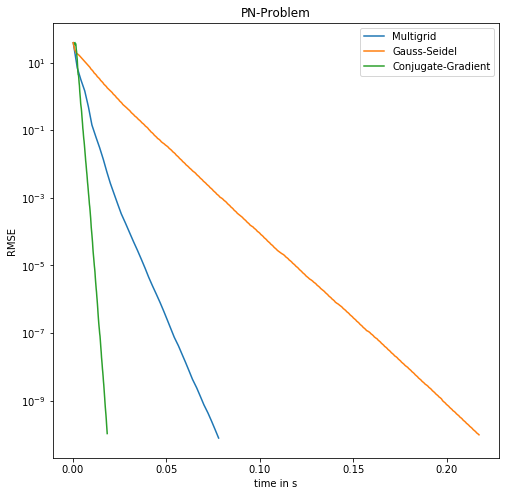

In [152]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/homogeneous_test.mat"
data = scipy.io.loadmat(filename)
coeff = 0
numCoeffs = data["numCoeffs"][0][0]

image = util.extract_coefficient_field( data["x"], data["resolution"][0], numCoeffs, coeff )
image = np.clip(image, 1.0e-8, np.max(image))


fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
#plt.title("Solution of LSPN0, which just has a single cofficient")
img_view = ax.imshow(image[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

plt.show()

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.title("PN-Problem")
plot_timings2(filename)
plt.legend(loc='best')
plt.xlabel('time in s')
plt.ylabel('RMSE')
plt.show()


------------------------------------

### More iterations in lower resolution grids.

With the next test we increase the number of smoothing steps with each level. The finest level will do one smoothing step and level $n$ will do $2^n$ smoothing steps per multigrid iteration.

In [212]:
def plot_timings3( filename, special = "Multigrid2" ):
    data = scipy.io.loadmat(filename)
    if "convergence_mg" in data:
        convergence_mg = data["convergence_mg"][0]
        convergence_time_mg = data["timestamps_mg"][0]
        plt.semilogy( convergence_time_mg, convergence_mg, label="Multigrid" )
    if "convergence_mg2" in data:
        convergence_mg2 = data["convergence_mg2"][0]
        convergence_time_mg2 = data["timestamps_mg2"][0]
        plt.semilogy( convergence_time_mg2, convergence_mg2, label=special )
    if "convergence_gs" in data:
        convergence_gs = data["convergence_gs"][0]
        convergence_time_gs = data["timestamps_gs"][0]
        plt.semilogy( convergence_time_gs, convergence_gs, label="Gauss-Seidel" )
    if "convergence_cg" in data:
        convergence_cg = data["convergence_cg"][0]
        convergence_time_cg = data["timestamps_cg"][0]
        plt.semilogy( convergence_time_cg, convergence_cg, label="Conjugate-Gradient" )
def plot_iterations( filename, special = "Multigrid2" ):
    data = scipy.io.loadmat(filename)
    if "convergence_mg" in data:
        convergence_mg = data["convergence_mg"][0]
        plt.semilogy( convergence_mg, label="Multigrid" )
    if "convergence_mg2" in data:
        convergence_mg2 = data["convergence_mg2"][0]
        plt.semilogy( convergence_mg2, label=special )
    if "convergence_gs" in data:
        convergence_gs = data["convergence_gs"][0]
        plt.semilogy( convergence_gs, label="Gauss-Seidel" )
    if "convergence_cg" in data:
        convergence_cg = data["convergence_cg"][0]
        plt.semilogy( convergence_cg, label="Conjugate-Gradient" )

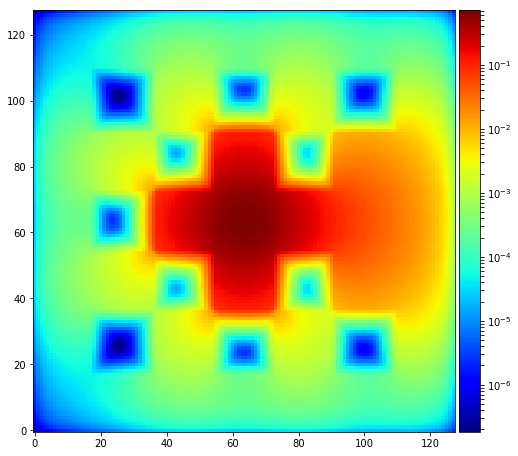

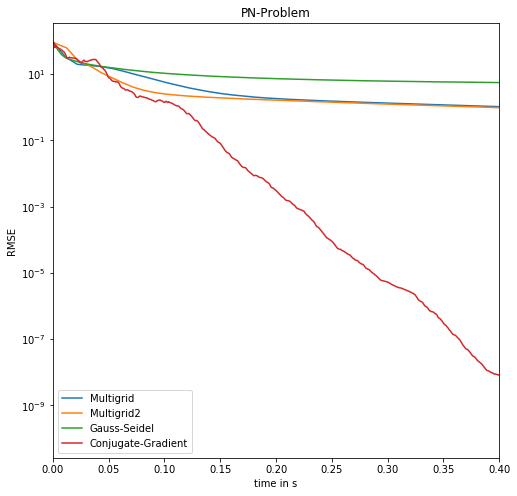

In [198]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
data = scipy.io.loadmat(filename)
coeff = 0
numCoeffs = data["numCoeffs"][0][0]

image = util.extract_coefficient_field( data["x"], data["resolution"][0], numCoeffs, coeff )
image = np.clip(image, 1.0e-8, np.max(image))


fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
#plt.title("Solution of LSPN0, which just has a single cofficient")
img_view = ax.imshow(image[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

plt.show()

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.title("PN-Problem")
plot_timings3(filename)
plt.legend(loc='best')
plt.xlim(0, .4)
plt.xlabel('time in s')
plt.ylabel('RMSE')
plt.show()


------------------------------------

### Test

For the following test, we solve the coarse problem (level 1) up to final precision BEFORE starting the clock and use the result as intial guess of the CG solve for the finer level (using upsampling). It is remarkable, that the speedup is so little. Using the upsampled result from a coarse solve as initial guess does not improve performance of the CG solve significantly.

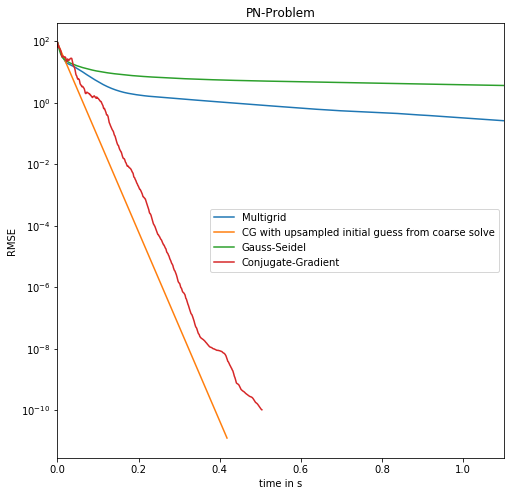

In [200]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.title("PN-Problem")
plot_timings3(filename, "CG with upsampled initial guess from coarse solve")
plt.legend(loc='best')
plt.xlim(0, 1.1)
plt.xlabel('time in s')
plt.ylabel('RMSE')
plt.show()

----------------------------

### Block Gauss-Seidel

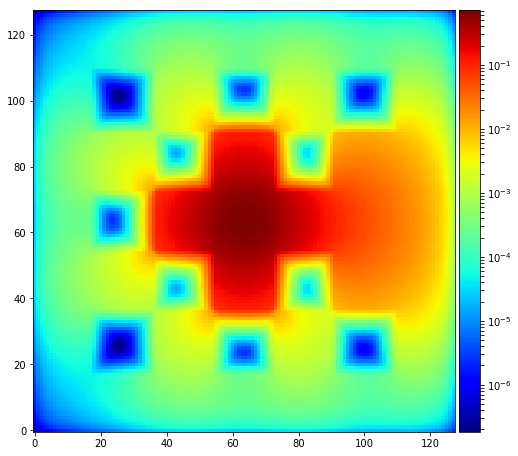

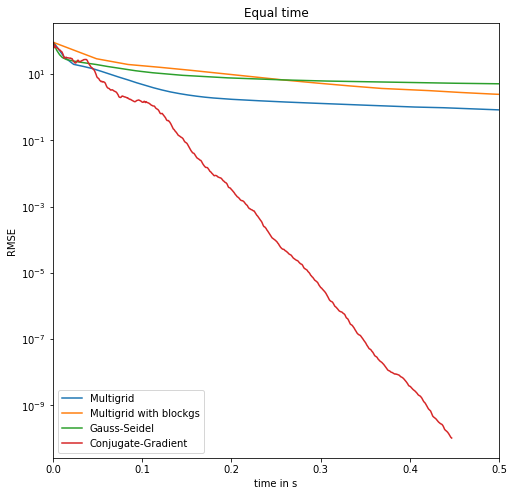

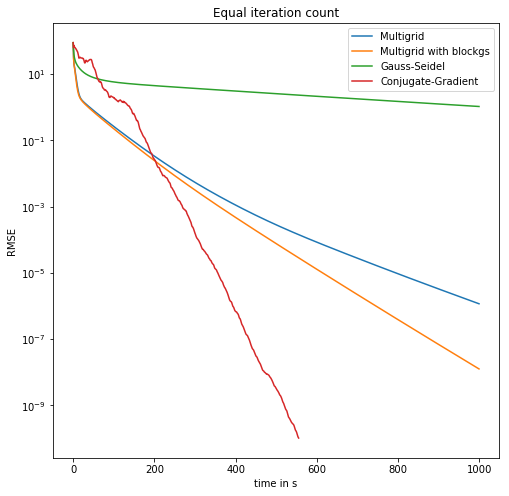

In [221]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
data = scipy.io.loadmat(filename)
coeff = 0
numCoeffs = data["numCoeffs"][0][0]

image = util.extract_coefficient_field( data["x"], data["resolution"][0], numCoeffs, coeff )
image = np.clip(image, 1.0e-8, np.max(image))


fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
#plt.title("Solution of LSPN0, which just has a single cofficient")
img_view = ax.imshow(image[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

plt.show()

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.title("Equal time")
plot_timings3(filename, "Multigrid with blockgs")
plt.legend(loc='best')
#plt.xlim(0, 1.1)
plt.xlim(0, 0.5)
plt.xlabel('time in s')
plt.ylabel('RMSE')
plt.show()

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.title("Equal iteration count")
plot_iterations(filename, "Multigrid with blockgs")
plt.legend(loc='best')
#plt.xlim(0, 1.1)
#plt.xlim(0, 0.5)
plt.xlabel('time in s')
plt.ylabel('RMSE')



plt.show()